This notebook will introduce you to the most typical analysis of electronic structure: Bands, fatbands and projected density of states.

We will do the analysis for graphene on the results of a SIESTA simulation.

In [1]:
import sisl
import sisl.viz
import plotly.express as px

## Create a graphene structure 
Create a graphene structure and save it for SIESTA calculation

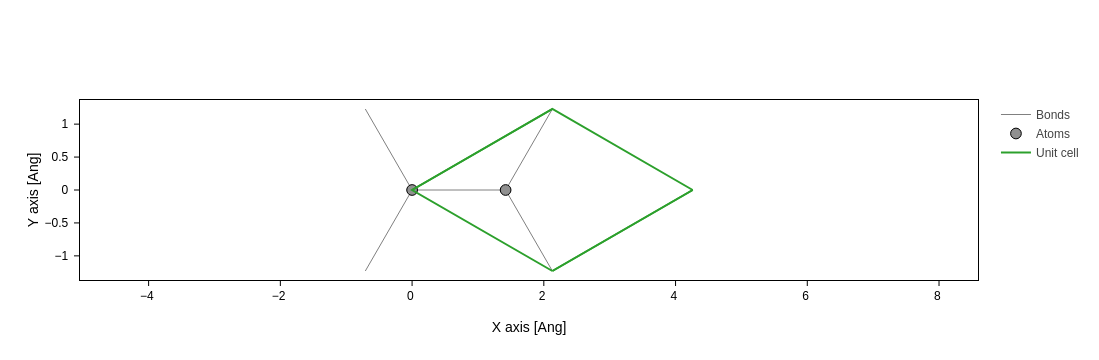

In [5]:
# Create a graphene structure with the default parameters.
graphene = sisl.geom.graphene()
# Plot it to see that it is what we wanted
graphene.plot(axes="x,y")

In [6]:
graphene.write("structure.fdf")

Graphene tight binding (the easy way)
----
Now that you know everything you need to consider to make a tight binding model work, you will appreciate more how `sisl` makes it easy for you to create one. We will do it in simple steps:

#### Create a structure

The first step to have a tight binding model is creating the atomic structure that you want to model. In general, you don't need to calculate the coordinates of the geometry yourself. `sisl` has functions that allow you to automatically create common geometries (see [here](https://zerothi.github.io/sisl/api/default_geom.html?highlight=geom#module-sisl.geom)). To generate molecules, the [`ASE` package](https://wiki.fysik.dtu.dk/ase/) has a very useful `build` function.

Let's build a graphene structure:

In [ ]:
graphene = sisl.geom.graphene()

Let's check what it is:

In [ ]:
graphene

Now that we know it is a `Geometry` object, we can go to sisl's documentation to see all the [methods that we can use](https://zerothi.github.io/sisl/api/generated/sisl.Geometry.html?highlight=geometry#sisl.Geometry) on it to manipulate the structure, measure things, etc...

We can now plot it to see how it looks:

In [ ]:
graphene.plot(axes="xy")

The coordinates are stored under the `xyz` attribute:

In [ ]:
graphene.xyz

And the lattice vectors can be found under `cell`:

In [ ]:
graphene.cell

Just as an example, we can use the `move` method to  modify the structure a bit:

In [ ]:
modified_graphene = graphene.move([-0.1, 0.1, 0], atoms=1)

Let's see how it looks now:

In [ ]:
modified_graphene.plot(axes="xy")

**Challenge:** Look at the documentation and try to create a 7-atoms wide graphene nanoribbon structure. Plot it to see that it is what you want.

We could do lots of things here, but we will stick to our graphene structure for our first tight binding model.

#### Build a Hamiltonian

This is as easy as:

In [ ]:
H = sisl.Hamiltonian(graphene)
H

However, this hamiltonian doesn't contain any values yet, we have to populate it. There is a very easy way to do this: the `construct` method. It needs a list with two items:
- A list of cutoff radius.
- A list containing, for each cutoff radius, the interaction parameter between atoms.
So, effectively, if we want to construct a tight binding hamiltonian with onsite energy $e = 0$ and first neighbour hopping $\gamma=-2.7$, we would do something like this:

In [ ]:
H.construct([(0.1, 1.5), (-0.2, -2.7)])

Where we have specified that for atoms closer than 0.1 Ang (i.e. interaction of an atom with itself) the interaction term is 0 eV, and for atoms at a distance between 0.1 and 1.5 Ang (first neighbours) the interaction parameter is -2.7 eV.

Let's check what the actual values of the hamiltonian are: 

In [ ]:
H.tocsr().toarray()

We can see that **it's not actually a 2x2 hamiltonian**, as maybe you'd expect. This is the hamiltonian matrix containing all the interactions of atoms 0 and 1 (rows), with all the potential neighbouratoms in a 3x3 supercell. This means that there are 9 potential cells that can interact with the unit cell, with two atoms each. This results in a 2x18 hamiltonian matrix:

In [ ]:
px.imshow(H.tocsr().toarray(), color_continuous_scale="gray", text_auto=True, height=300)

You can try to understand it by looking at the interactions of the unit cell atoms with the rest:

In [ ]:
graphene.plot(nsc=[3,3,1], axes="xy").update_traces(
    selector={"name": "Atoms"}, mode="markers+text", text=["0", "1"]*9, textposition="top center"
)

Now, for a given $k$, you can get $H_k$, which is calculated using the phases of each interaction, and everything ends up folded in a 2x2 matrix, as the matrices that you have been building: 

In [ ]:
H.Hk(k=(0,0,0)).tocsr().toarray()

#### Getting the eigenstates

You could diagonalize this hamiltonian yourself, but there is the `eigenstate` method that automatically does this for you:

In [ ]:
eigenstate = H.eigenstate(k=(0,0,0))
eigenstate

It returns an `EigenstateElectron` object, which contains the eigenvalues (`eig`) and the eigenstates (`state`):

In [ ]:
eigenstate.eig, eigenstate.state

#### Plotting a band structure
You could loop through all the $k$ values yourself as you did in the previous tasks, but sisl provides useful objects for sampling k-spaces. One of them is `BandStructure`, which is useful for 1D paths of k points.

**NOTE**: There's also `MonkhorstPack`, which is equivalent to the monkhorst pack grid in SIESTA.

In [ ]:
band_struct = sisl.BandStructure(
    H, # The hamiltonian that we want to diagonalize for each k point.
    points=[[0, 0, 0], [2/3, 1/3, 0], [1/2, 0, 0]], # The corners of the path
    divisions=5, # The number of k points
    names=[r"\Gamma", "M", "K"]
)
band_struct

We can now apply the `eigh` method to get the eigen energies for each k point in our sampling:

In [ ]:
band_struct.apply.array.eigh()

But if what we want is to plot the bands, sisl already provides a `plot` method to you:

In [ ]:
band_struct.plot()

### Summary

As a summary here's the code to build a graphene tight binding model in `sisl`:

In [ ]:
# Create the geometry
graphene = sisl.geom.graphene()
# Create the hamiltonian
H = sisl.Hamiltonian(graphene)
# Construct the hamiltonian with the values that we want
H.construct([(0.1, 1.5), (0, -2.7)])

And now we can play with it to plot the bands:

In [ ]:
# We need to define a path of k points
band_struct = sisl.BandStructure(H, points=[[0, 0, 0], [2/3, 1/3, 0], [1/2, 0, 0]],
    divisions=200, names=[r"\Gamma", "M", "K"]
)
# Then we can plot the bands
band_struct.plot()

Also, the **fatbands**. In fatbands, the width of each band represents the coefficient of a particular basis orbital for that band at that k-point. Usually, you draw multiple orbitals (or groups of orbitals), each in one colour. The **wider the band is for a given color, the more contribution of the orbital to the state** (bigger coefficient).

Here's how you can get them:

In [ ]:
# Get the fatbands plot
fatbands = band_struct.plot.fatbands()
# Split the contributions by atoms to see how each atom contributes to the bands
fatbands.split_groups(on="atoms", name="Atom $atoms")

In this plot we can see that all atoms contribute exactly equally to each state.

Then there is the **projected density of states** (*PDOS*). A PDOS plot allows you to visualize not only the density of states of a structure, but also how particular basis orbitals (or groups of them) contribute to it. You can easily get it from the hamiltonian. There are several parameters that are crucial for this analysis:
- The k point sampling (`kgrid`).
- The energy range (`Erange`) and number of energy points at which we calculate the DOS (`nE`).
- The function/distribution used to smooth out the curve (`distribution`).

We provide here some good values, but you can play with them:

In [ ]:
# Get the PDOS plot
pdos_plot = H.plot.pdos(
    kgrid=[90,90,1], nE=1000, data_Erange=[-10, 10], Erange=[-10,10],
    distribution=sisl.get_distribution(method="gaussian", smearing=0.1)
)
# Split the contributions by atoms to see how each atom contributes to the DOS
pdos_plot.split_DOS(on="atoms", name="Atom $atoms")

We can also see here that both atoms contribute exactly the same to the density of states.

**TASK 1**: By checking the bands, there seems to be states all over the energy range. However, the density of states is much higher at around -2eV than at 0 eV. Explain why using the plotted bands.

**TASK 2**: The difference between a graphene tight binding and a boron nitride (h-BN) one is that in h-BN the onsite terms of each atom are different ($e_0 \ne e_1$). The common approach is to make them have the same magnitude but of opposite sign ($e_0 = -e_1$). In the cell where we define our tight binding $H$, after building it, update the `H[0,0]` and `H[1,1]` terms appropiately to have a h-BN tight binding. Plot the bands, fatbands and PDOS again and explain what happens.

**TASK 3**: The following code displays the DOS analysis of our tight binding hamiltonian for a various number of smearing values of number of k points. Keep in mind that **there's only one valid** answer to the problem of finding the **DOS**, the variability shown here is a result of not good enough numerical analysis. This is a key fact to understand: **for your numerical analysis to be right, the parameters need to be right**. With the help of the plot explain:
1. In general, what is the effect of the smearing parameter and the number of k points in the PDOS analysis?
2. Which combination of parameters do you consider a good DOS representation? Which one is cheaper to compute?
3. With low kpoint sampling (between 1 and 6 k-points), you can see a peak appearing at 0 eV only when nk=3 or nk=6. Why does that peak appear only for those values of nk?

In [ ]:
import itertools

plots = []
nkpoints_values = [1, 2, 3, 4, 5, 6, 9, 21, 50, 90]
smearing_values = [1e-3, 0.1, 0.2]
for nkpoints, smearing in itertools.product(nkpoints_values, smearing_values):
    plot = H.plot.pdos(
        kgrid=[nkpoints, nkpoints,1], nE=300, data_Erange=[-10, 10], Erange=[-10, 10],
        distribution=sisl.get_distribution(method="gaussian", smearing=smearing)
    )

    plots.append(plot)
    
sisl.viz.merge_plots(
    *plots, 
    composite_method="subplots",
    cols=3,
    row_titles=[f"nk={nk}" for nk in nkpoints_values],
    column_titles=[f"smearing={s}" for s in smearing_values]
).update_xaxes(
    title=""
).update_yaxes(
    title=""
).update_traces(
  line_color="black"  
).update_layout(height=1500, showlegend=False)

Graphene with SIESTA
----

**TASK 4:** We performed an analysis of our structure with a tight binding hamiltonian ($H$). However, it really doesn't matter where the $H$ comes from, as long as you have one. You can make SIESTA write the final Hamiltonian with the flag:

```
TS.HS.Save true
```

in your fdf. Rerun one of your graphene calculations with this flag and analyze the bands, fatbands and PDOS as we did with the tight binding hamiltonian. The main difference is that we will now have much more basis orbitals. We can then split the fatbands and PDOS contributions by orbitals and see how different orbitals contribute to them. **Explain the results you get in comparison to the tight binding**.

**NOTE**: Use also `SaveRho true` in your fdf file to make SIESTA store the electronic density ($\rho$, rho), we will then display it just for fun, so that you can see how it can be done and what it looks like.

**NOTE 2**: The plots generated in this notebook are documented [here](https://zerothi.github.io/sisl/visualization/viz_module/index.html#showcase-of-plot-classes) in a very visual way. If you want to change the parameters, you can look at the documentation.

Rerun your calculation, and then use the next cells to get the analysis.

First, we will need to read the hamiltonian from your simulation. Once the simulation is finished you can read it like this:

In [ ]:
# Substitute path/to/your.fdf by the actual path to your fdf.
H = sisl.get_sile("path/to/your.fdf").read_hamiltonian()

And then perform the analysis:

#### Bands

In [ ]:
# We need to define a path of k points
band_struct = sisl.BandStructure(H, points=[[0, 0, 0], [2/3, 1/3, 0], [1/2, 0, 0]],
    divisions=100, names=[r"\Gamma", "M", "K"]
)
# Then we can plot the bands
band_struct.plot()

#### Fatbands

In [ ]:
# Get the fatbands plot
fatbands = band_struct.plot.fatbands()
# Split the contributions by the n and l quantum numbers
fatbands.split_groups(on="n+l")

#### PDOS

In [ ]:
# Get the PDOS plot
pdos_plot = H.plot.pdos(
    kgrid=[90,90,1], nE=1000, Erange=[-10, 10],
    distribution=sisl.get_distribution(method="gaussian", smearing=0.1)
)
# Split the contributions by the n and l quantum numbers
pdos_plot.split_DOS(on="n+l", name="Atom $atoms")

**Just for fun:**

If you have used `SaveRho true`, we can now plot the electronic density ($\rho$, rho):

In [ ]:
rho = sisl.get_sile("path/to/your.fdf").read_grid("RHO")

In [ ]:
rho.plot(axes="xy", plot_geom=True)